In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#base_dir = '/content/drive/MyDrive/ИЦ им. Ханны Арендт/Мобилизация/'
base_dir = '/content/drive/MyDrive/'
before_date = '03.11.2022'
after_date = '01.02.2023'

### setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

def get_stars(p):
    if p < 0.001:
        return '****'
    if p < 0.01:
        return '***'
    if p < 0.05:
        return '**'
    if p < 0.10:
        return '*'
    return ''

def get_APA(ols, sig=False): #R^2=.34, F(1,416)=6.71, p=.009
  r_sq = f'{ols.rsquared:.2f}'[1:]
  df_m = int(ols.df_model)
  df_r = int(ols.df_resid)
  f_v = f'{ols.fvalue:.2f}'[1:] if ols.fvalue < 1 else f'{ols.fvalue:.2f}'
  p_v = f'{ols.f_pvalue:.3f}'[1:] if ols.f_pvalue >= 0.001 else '.001'
  lvl = '<' if ols.f_pvalue < 0.001 else '='
  sig = get_stars(ols.f_pvalue) if sig else ''
  return f"R²={r_sq}, F({df_m}, {df_r})={f_v}, p{lvl}{p_v}{sig}"

def calc_OLS(data, y, x, standardized=False, rename_dict=None):
    _d = data
    if standardized:
      scaler = StandardScaler()
      scaler.fit(_d)
      __d = scaler.transform(_d)
      __d=pd.DataFrame(__d)
      __d.columns = _d.columns
      _d = __d
    f = f'{y} ~ 1 + ' + '+'.join([i for i in x if i in _d])
    print(f)
    ols = smf.ols(f, _d).fit(cov_type='HC1')
    #print(ols.summary())
    robust = smf.rlm(f, _d, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
    #print(robust.summary())
    base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                                  'std err' : 'std_err',
                                                                                  '[0.025' : 'CIL',
                                                                                  '0.975]' : 'CIR'})
    base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]
    robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                                  'std err' : 'std_err',
                                                                                  '[0.025' : 'CIL',
                                                                                  '0.975]' : 'CIR'})
    robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
    robust_ols.columns = [i+'_robust' for i in robust_ols.columns]
    x = pd.Series(x).rename('feature')
    x = pd.concat([x, x.rename('i')], axis=1).set_index('i')
    robust_ols = x.join(robust_ols, how='left')
    results = robust_ols.join(base_ols, how='left').reset_index()
    if 'i' in results:
      results.drop('i', axis=1, inplace=True)
    if rename_dict:
        results['feature'] = results['feature'].apply(lambda x: rename_dict[x] if x in rename_dict else x)
    return results, get_APA(ols)

### data load

In [ ]:
main_df_norm = pd.read_csv(os.path.join(base_dir, 'main_df_norm.csv'))

In [ ]:
cv_mean_count_diff = pd.read_csv(os.path.join(base_dir, 'cv_mean_count_diff.csv'), sep=';')

In [ ]:
excess_before = pd.read_csv(os.path.join(base_dir, f'cv_excess_{before_date}.csv'), sep=';').rename(columns={'excess_value': 'excess_value_before'})
excess_after = pd.read_csv(os.path.join(base_dir, f'cv_excess_{after_date}.csv'), sep=';').rename(columns={'excess_value': 'excess_value_after'})
excess = pd.merge(excess_before, excess_after, on='region_name')[['region_name', 'excess_value_before', 'excess_value_after']]
r = pd.read_csv(os.path.join(base_dir, f'regions.csv'), sep=';', dtype='str')
excess = excess.merge(r[['region_code', 'region_name']], how='left', on='region_name')
excess['region_code'] = pd.to_numeric(excess['region_code'])

In [ ]:
production = pd.read_csv(os.path.join(base_dir, f'production.csv'), sep=',')
production = production.merge(r[['region_code', 'region_name']], how='left', on='region_name')
production['region_code'] = pd.to_numeric(production['region_code'])

In [ ]:
dotation = pd.read_csv(os.path.join(base_dir, f'dotations_2022.csv'), sep=',')

In [ ]:
vrp_struct = pd.read_excel(os.path.join(base_dir, f'vrp-struct.xlsx')).merge(r[['region_code', 'region_name']], how='left', on='region_name').drop('region_name', axis=1)
vrp_struct['region_code'] = pd.to_numeric(vrp_struct['region_code'])

In [ ]:
with open(os.path.join(base_dir, 'industry_dict.pickle'), 'rb') as pf:
    vac_industry_dict = pickle.load(pf)
with open(os.path.join(base_dir, 'vac_industry.pickle'), 'rb') as pf:
    vac_industry = pickle.load(pf)
len(vac_industry)

530510

In [ ]:
vac = vac_industry.copy()
vac = vac[(vac['date_create'] >= '2022-09-21') & (vac['date_create'] <= '2022-12-31')]
vac = vac_industry.groupby('region_code').count()[['id']].rename(columns={'id' : 'vac_count'}).reset_index()
vac['region_code'] = pd.to_numeric(vac['region_code'])
if 'region_name' in vac:
  vac.drop('region_name', axis=1, inplace=True)

In [ ]:
'''
vac_count = vac_industry.groupby('region_code').mean().rename(columns={'id' : 'vac_count'}).reset_index()
vac_count['region_code'] = pd.to_numeric(vac_count['region_code'])
if 'region_name' in vac_count:
  vac_count.drop('region_name', axis=1, inplace=True)
'''

"\nvac_count = vac_industry.groupby('region_code').mean().rename(columns={'id' : 'vac_count'}).reset_index()\nvac_count['region_code'] = pd.to_numeric(vac_count['region_code'])\nif 'region_name' in vac_count:\n  vac_count.drop('region_name', axis=1, inplace=True)\n"

In [ ]:
#Лесозаготовки:
#https://xn--80aegj1b5e.xn--p1ai/publication/lesopromyshlennyy-kompleks
#Амурской, Архангельской, Иркутской, Кировской, Костромской, Пермской, Томской областей; Красноярского и Хабаровского края; в Республике Коми. Челябинская свердловская тюменская
#Одним из самых развитых регионов, который имеет на своей территории богатые лесные ресурсы и производит лесозаготовку в больших объемах – это Урал.
#Лесная промышленность также развита в Карелии, республики Удмуртии, Тюменской области и Архангельской области. В этих регионах располагаются самые крупные предприятия лесопиления.
#https://communa.ru/prochie_novosti_07_2019/lesnaya-promyshlennost-v-rossii-gde-nakhodyatsya-osnovnye-proizvodstva/
#https://fabricators.ru/proizvodstvo/lesozagotovitelnye-predpriyatiya
r['forest'] = 0
r.loc[r.region_name == 'Архангельская область', 'forest'] = 1
r.loc[r.region_name == 'Удмуртская Республика', 'forest'] = 1
r.loc[r.region_name == 'Республика Карелия', 'forest'] = 1
r.loc[r.region_name == 'Челябинская область', 'forest'] = 1
r.loc[r.region_name == 'Тюменская область', 'forest'] = 1
r.loc[r.region_name == 'Свердловская область', 'forest'] = 1
r.loc[r.region_name == 'Республика Коми', 'forest'] = 1
r.loc[r.region_name == 'Хабаровский край', 'forest'] = 1
r.loc[r.region_name == 'Красноярский край', 'forest'] = 1
r.loc[r.region_name == 'Томская область', 'forest'] = 1
r.loc[r.region_name == 'Пермский край', 'forest'] = 1
r.loc[r.region_name == 'Костромская область', 'forest'] = 1
r.loc[r.region_name == 'Кировская область', 'forest'] = 1
r.loc[r.region_name == 'Иркутская область', 'forest'] = 1
r.loc[r.region_name == 'Амурская область', 'forest'] = 1
r['auto'] = 0
#https://xn--80aegj1b5e.xn--p1ai/factories/avtomobilnye-zavody
r.loc[r.region_name == 'Брянская область', 'auto'] = 1
r.loc[r.region_name == 'Калужская область', 'auto'] = 1
r.loc[r.region_name == 'Московская область', 'auto'] = 1
r.loc[r.region_name == 'Калининградская область', 'auto'] = 1
r.loc[r.region_name == 'Ленинградская область', 'auto'] = 1
r.loc[r.region_name == 'Челябинская область', 'auto'] = 1
r.loc[r.region_name == 'Республика Татарстан', 'auto'] = 1
r.loc[r.region_name == 'Удмуртская Республика', 'auto'] = 1
r.loc[r.region_name == 'Нижегородская область', 'auto'] = 1
r.loc[r.region_name == 'Самарская область', 'auto'] = 1
r.loc[r.region_name == 'Ульяновская область', 'auto'] = 1
r.loc[r.region_name == 'Тюменская область', 'auto'] = 1
r.loc[r.region_name == 'Липецкая область', 'auto'] = 1
r.loc[r.region_name == 'Ставропольский край', 'auto'] = 1
r.loc[r.region_name == 'Воронежская область', 'auto'] = 1
#https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D0%BE%D1%80%D0%BE%D0%BD%D0%BD%D0%BE-%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BB%D0%B5%D0%BA%D1%81_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8#:~:text=%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B5%20%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8%20%D0%9E%D0%9F%D0%9A%3A%20%C2%AB%D0%A0%D0%BE%D1%81%D1%82%D0%B5%D1%85%C2%BB,%D0%B7%D0%B0%D0%B2%D0%BE%D0%B4%2C%20%D0%92%D0%BE%D1%82%D0%BA%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%B7%D0%B0%D0%B2%D0%BE%D0%B4%20%D0%B8%20%D0%B4%D1%80%D1%83%D0%B3%D0%B8%D0%B5.
r['vpk'] = 0
r.loc[r.region_name == 'Нижегородская область', 'vpk'] = 1
r.loc[r.region_name == 'Пензенская область', 'vpk'] = 1
r.loc[r.region_name == 'Свердловская область', 'vpk'] = 1
r.loc[r.region_name == 'Челябинская область', 'vpk'] = 1
r.loc[r.region_name == 'Томская область', 'vpk'] = 1
r.loc[r.region_name == 'Красноярский край', 'vpk'] = 1
r.loc[r.region_name == 'Иркутская область', 'vpk'] = 1
r.loc[r.region_name == 'Московская область', 'vpk'] = 1
r.loc[r.region_name == 'Калининградская область', 'vpk'] = 1
r.loc[r.region_name == 'Ленинградская область', 'vpk'] = 1
r.loc[r.region_name == 'Воронежская область', 'vpk'] = 1
r.loc[r.region_name == 'Ростовская область', 'vpk'] = 1
r.loc[r.region_name == 'Волгоградская область', 'vpk'] = 1
r.loc[r.region_name == 'Саратовская область', 'vpk'] = 1
r.loc[r.region_name == 'Республика Татарстан', 'vpk'] = 1
r.loc[r.region_name == 'Ульяновская область', 'vpk'] = 1
r.loc[r.region_name == 'Самарская область', 'vpk'] = 1
r.loc[r.region_name == 'Кировская область', 'vpk'] = 1
r.loc[r.region_name == 'Удмуртская Республика', 'vpk'] = 1
r.loc[r.region_name == 'Пермский край', 'vpk'] = 1
r.loc[r.region_name == 'Омская область', 'vpk'] = 1
r.loc[r.region_name == 'Алтайский край', 'vpk'] = 1
r.loc[r.region_name == 'Новосибирская область', 'vpk'] = 1
r.loc[r.region_name == 'Смоленская область', 'vpk'] = 1
r.loc[r.region_name == 'Калужская область', 'vpk'] = 1
r.loc[r.region_name == 'Республика Башкортостан', 'vpk'] = 1
r.loc[r.region_name == 'Республика Бурятия', 'vpk'] = 1
r.loc[r.region_name == 'Хабаровский край', 'vpk'] = 1
r.loc[r.region_name == 'Приморский край', 'vpk'] = 1
r.loc[r.region_name == 'г. Санкт-Петербург', 'vpk'] = 1
'''
С Украиной граничат 6 субъектов РФ. Брянская, Курская, Белгородская, Воронежская области имеют границу по суше,
Краснодарский край граничит с Украиной по Азовскому морю и Керченскому проливу,
а Ростовская область имеет комбинированную границу – по суше и Азовскому морю.
'''
r['border'] = 0
r.loc[r.region_name == 'Брянская область', 'border'] = 1
r.loc[r.region_name == 'Курская область', 'border'] = 1
r.loc[r.region_name == 'Белгородская область', 'border'] = 1
r.loc[r.region_name == 'Воронежская область', 'border'] = 1
r.loc[r.region_name == 'Ростовская область', 'border'] = 1
r.loc[r.region_name == 'Краснодарский край', 'border'] = 1

In [ ]:
r['region_code'] = pd.to_numeric(r['region_code'])
main_df_norm = pd.merge(main_df_norm, vac, on='region_code')
main_df_norm = pd.merge(main_df_norm, r[['region_code', 'forest', 'auto', 'vpk', 'border']], on='region_code')
main_df_norm = pd.merge(main_df_norm, cv_mean_count_diff, on='region_code')
main_df_norm = pd.merge(main_df_norm, vrp_struct, on='region_code')
main_df_norm = pd.merge(main_df_norm, excess, on='region_code')
main_df_norm = pd.merge(main_df_norm, dotation[['dotation_2022', 'region_code', 'mean_unempl_days', 'mean_unempl_days_alltime']], on='region_code')
main_df_norm = pd.merge(main_df_norm, production[['max_drop', 'sum_change', 'sum_drop', 'max_drop_manuf',
       'sum_change_manuf', 'sum_drop_manuf', 'max_drop_power',
       'sum_change_power', 'sum_drop_power', 'max_drop_water',
       'sum_change_water', 'sum_drop_water', 'region_code']], on='region_code')

In [ ]:
if 'region_name' in main_df_norm:
  main_df_norm.drop('region_name', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(main_df_norm)
main_df_norm_scaled = scaler.transform(main_df_norm)
main_df_norm_scaled=pd.DataFrame(main_df_norm_scaled)
main_df_norm_scaled.columns = main_df_norm.columns

In [ ]:
main_df_norm_scaled.rename(columns={'Добыча полезных ископаемых': 'dobycha',
                             'Строительство' : 'stritelstvo',
                             'Оптовая торговля' : 'torgovlya'}, inplace=True)

In [ ]:
main_df_norm_scaled.to_csv(os.path.join(base_dir, 'main_df_norm_scaled.csv'), index=False, sep=';')

In [ ]:
main_df_norm_scaled.columns.tolist()

['economic_growth',
 'population',
 'excessive_voices',
 'gossluz',
 'income',
 'vote_turnout',
 'rate_yes',
 'internet',
 '_8014006',
 'city_people',
 'mans_only',
 'salary',
 'subsidii_flat',
 'subsidised_families_flat',
 'migration',
 'hospital',
 'subsidii',
 'weddings',
 'region_code',
 'cv',
 'poteri',
 'mobiliz',
 'dobrovol',
 'Место',
 'Соотношение среднедушевого долга по кредитам и годовой зарплаты в начале 2022 г., %',
 'indebted',
 'Изменение задолженности на\xa0одного человека за\xa0год, тыс. руб.',
 'poverty_ratio',
 'zaderzania',
 'antiwar_zaderzania',
 'mean_living_subsid',
 'vac_count',
 'forest',
 'auto',
 'vpk',
 'border',
 'cv_mean_count_diff2022',
 'cv_mean_count_diff2023',
 'cv_mean_count_difffeb',
 'сх, лес, рыба',
 'dobycha',
 'Обрабатывающее произв',
 'Электроэнергия, газ',
 'Водоснаб',
 'stritelstvo',
 'torgovlya',
 'Траспорт',
 'Общественное питание, гостиницы',
 'Информация и связь',
 'Финансы и страхование',
 'Недвижимость',
 'Наука и техника',
 'администр',

### hypoteses testing

In [ ]:
main_df_norm.columns.to_list()

['economic_growth',
 'population',
 'excessive_voices',
 'gossluz',
 'income',
 'vote_turnout',
 'rate_yes',
 'internet',
 '_8014006',
 'city_people',
 'mans_only',
 'salary',
 'subsidii_flat',
 'subsidised_families_flat',
 'migration',
 'hospital',
 'subsidii',
 'weddings',
 'region_code',
 'cv',
 'poteri',
 'mobiliz',
 'dobrovol',
 'Место',
 'Соотношение среднедушевого долга по кредитам и годовой зарплаты в начале 2022 г., %',
 'indebted',
 'Изменение задолженности на\xa0одного человека за\xa0год, тыс. руб.',
 'poverty_ratio',
 'zaderzania',
 'antiwar_zaderzania',
 'mean_living_subsid',
 'vac_count',
 'forest',
 'auto',
 'vpk',
 'border',
 'cv_mean_count_diff2022',
 'cv_mean_count_diff2023',
 'cv_mean_count_difffeb',
 'сх, лес, рыба',
 'Добыча полезных ископаемых',
 'Обрабатывающее произв',
 'Электроэнергия, газ',
 'Водоснаб',
 'Строительство',
 'Оптовая торговля',
 'Траспорт',
 'Общественное питание, гостиницы',
 'Информация и связь',
 'Финансы и страхование',
 'Недвижимость',
 'Нау

In [ ]:
main_df_norm_scaled[['cv', 'vac_count']].corr()

,cv,vac_count
cv,1.000000,-0.233817
vac_count,-0.233817,1.000000


In [ ]:
main_df_norm_scaled[['dotation_2022', 'mean_unempl_days_alltime','mean_living_subsid', 'subsidised_families_flat']].corr()

,dotation_2022,mean_unempl_days_alltime,mean_living_subsid,subsidised_families_flat
dotation_2022,1.000000,0.434506,-0.083059,-0.017076
mean_unempl_days_alltime,0.434506,1.000000,-0.011532,0.008788
mean_living_subsid,-0.083059,-0.011532,1.000000,-0.026137
subsidised_families_flat,-0.017076,0.008788,-0.026137,1.000000


In [ ]:
main_df_norm_scaled[['poverty_ratio', 'indebted', 'income', 'salary','mean_living_subsid']].corr()

,poverty_ratio,indebted,income,salary,mean_living_subsid
poverty_ratio,1.000000,0.438560,0.577298,0.043498,-0.073845
indebted,0.438560,1.000000,0.546751,0.100647,-0.084711
income,0.577298,0.546751,1.000000,0.080818,-0.034913
salary,0.043498,0.100647,0.080818,1.000000,0.818413
mean_living_subsid,-0.073845,-0.084711,-0.034913,0.818413,1.000000


In [ ]:
features = ['dobycha', 'torgovlya', 'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'vpk', 'border', 'forest', 'poverty_ratio', 'indebted', 'city_people']
coef, r = calc_OLS(main_df_norm_scaled, 'cv', features)
r

cv ~ 1 + dobycha+torgovlya+sum_change_manuf+sum_drop_manuf+dotation_2022+vpk+border+forest+poverty_ratio+indebted+city_people


'R²=.59, F(11, 65)=8.04, p<.001'

In [ ]:
coef

,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,dobycha,0.0626,0.142,0.441,0.659,-0.216,0.341,,0.0794,0.144,0.551,0.581,-0.203,0.362,
1,torgovlya,-0.3410,0.137,-2.484,0.013,-0.610,-0.072,**,-0.3596,0.153,-2.350,0.019,-0.659,-0.060,**
2,sum_change_manuf,-0.3375,0.104,-3.240,0.001,-0.542,-0.133,***,-0.3483,0.123,-2.828,0.005,-0.590,-0.107,***
3,sum_drop_manuf,0.2554,0.106,2.401,0.016,0.047,0.464,**,0.2740,0.103,2.661,0.008,0.072,0.476,***
4,dotation_2022,0.1103,0.093,1.182,0.237,-0.073,0.293,,0.1203,0.075,1.614,0.107,-0.026,0.266,
5,vpk,0.0101,0.094,0.107,0.914,-0.174,0.194,,0.0257,0.088,0.291,0.771,-0.148,0.199,
6,border,0.1786,0.094,1.908,0.056,-0.005,0.362,*,0.1828,0.112,1.631,0.103,-0.037,0.403,
7,forest,0.0651,0.095,0.687,0.492,-0.121,0.251,,0.0609,0.077,0.795,0.427,-0.089,0.211,
8,poverty_ratio,-0.3149,0.134,-2.355,0.019,-0.577,-0.053,**,-0.3287,0.163,-2.019,0.043,-0.648,-0.010,**
9,indebted,0.3292,0.118,2.796,0.005,0.098,0.560,***,0.3260,0.115,2.847,0.004,0.102,0.550,***


In [ ]:
features = ['cv']#, 'dobycha', 'torgovlya', 'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'vpk', 'border', 'forest']#, 'poverty_ratio', 'indebted']
coef, r = calc_OLS(main_df_norm_scaled, 'vac_count', features, rename_dict=vac_industry_dict)
print(r)
display(coef)
#coef.to_csv('cv_vac.csv')

vac_count ~ 1 + cv
R²=.05, F(1, 75)=4.96, p=.029


,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,cv,-0.1792,0.099,-1.801,0.072,-0.374,0.016,*,-0.2338,0.105,-2.227,0.026,-0.44,-0.028,**


In [ ]:
features = ['cv', 'economic_growth', 'gossluz', 'income', 'internet', 'migration',
            'dobycha', 'torgovlya', 'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'vpk', 'border', 'forest', 'poverty_ratio', 'indebted']
coef, r = calc_OLS(main_df_norm_scaled, 'weddings', features, rename_dict=vac_industry_dict)
print(r)
display(coef)

weddings ~ 1 + cv+economic_growth+gossluz+income+internet+migration+dobycha+torgovlya+sum_change_manuf+sum_drop_manuf+dotation_2022+vpk+border+forest+poverty_ratio+indebted
R²=.62, F(16, 43)=7.36, p<.001


,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,cv,0.1351,0.128,1.057,0.291,-0.115,0.385,,0.0456,0.140,0.327,0.744,-0.228,0.319,
1,economic_growth,-0.2480,0.074,-3.344,0.001,-0.393,-0.103,***,-0.3142,0.128,-2.456,0.014,-0.565,-0.063,**
2,gossluz,0.2882,0.104,2.766,0.006,0.084,0.492,***,0.3260,0.107,3.043,0.002,0.116,0.536,***
3,income,-0.1275,0.119,-1.069,0.285,-0.361,0.106,,-0.1958,0.124,-1.574,0.116,-0.440,0.048,
4,internet,0.0156,0.095,0.164,0.869,-0.171,0.202,,0.0874,0.119,0.734,0.463,-0.146,0.321,
5,migration,-0.0467,0.090,-0.521,0.602,-0.222,0.129,,-0.0387,0.059,-0.652,0.514,-0.155,0.078,
6,dobycha,0.2350,0.128,1.835,0.067,-0.016,0.486,*,0.2669,0.155,1.724,0.085,-0.037,0.570,*
7,torgovlya,0.1405,0.144,0.976,0.329,-0.142,0.423,,0.2210,0.135,1.635,0.102,-0.044,0.486,
8,sum_change_manuf,-0.0759,0.104,-0.730,0.466,-0.280,0.128,,-0.1235,0.135,-0.916,0.360,-0.388,0.141,
9,sum_drop_manuf,0.0472,0.108,0.437,0.662,-0.164,0.259,,0.0621,0.087,0.714,0.475,-0.108,0.233,


# misc

In [ ]:
vac_industry_dict

In [ ]:
features = [f'ind{i}' for i in range(37)]
coef, r = calc_OLS(main_df_norm_scaled, 'cv', features, rename_dict=vac_industry_dict)
print(r)
display(coef)
coef.to_csv('cv_vac.csv')

cv ~ 1 + ind0+ind1+ind2+ind3+ind4+ind5+ind6+ind7+ind8+ind9+ind10+ind11+ind12+ind13+ind14+ind15+ind16+ind17+ind18+ind19+ind20+ind21+ind22+ind23+ind24+ind25+ind26+ind27+ind28+ind29+ind30+ind31+ind32+ind33+ind34+ind35+ind36
R²=.71, F(36, 40)=80.23, p<.001


,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,Производство,-0.3537,0.077,-4.613,0.000,-0.504,-0.203,****,-0.4044,0.149,-2.705,0.007,-0.697,-0.111,***
1,Здравоохранение и социальное обеспечение,0.0409,0.076,0.535,0.593,-0.109,0.191,,0.0682,0.143,0.477,0.633,-0.212,0.349,
2,"Образование, наука",0.4499,0.126,3.562,0.000,0.202,0.697,****,0.4840,0.222,2.179,0.029,0.049,0.919,**
3,"Продажи, закупки, снабжение, торговля",0.1637,0.104,1.578,0.115,-0.040,0.367,,0.2303,0.147,1.566,0.117,-0.058,0.519,
4,"Транспорт, автобизнес, логистика, склад, ВЭД",0.2331,0.128,1.816,0.069,-0.018,0.485,*,0.2238,0.245,0.913,0.361,-0.257,0.705,
5,Пищевая промышленность,0.0693,0.092,0.757,0.449,-0.110,0.249,,0.0246,0.182,0.135,0.892,-0.333,0.382,
6,"ЖКХ, эксплуатация",-0.0892,0.112,-0.797,0.426,-0.309,0.130,,-0.0622,0.159,-0.392,0.695,-0.373,0.249,
7,"Строительство, ремонт, стройматериалы, недвижи...",-0.0172,0.116,-0.148,0.882,-0.245,0.210,,-0.0481,0.200,-0.240,0.810,-0.440,0.344,
8,"Консалтинг, стратегическое развитие, управление",-0.0392,0.112,-0.350,0.726,-0.259,0.180,,0.0919,0.208,0.442,0.659,-0.316,0.500,
9,"Сельское хозяйство, экология, ветеринария",0.1583,0.086,1.832,0.067,-0.011,0.328,*,0.1249,0.146,0.856,0.392,-0.161,0.411,


,feature,coef_robust,std_err_robust,z_robust,p-value_robust,CIL_robust,CIR_robust,sig_robust,coef,std_err,z,p-value,CIL,CIR,sig
0,ind0,-0.165,0.101,-1.633,0.102,-0.363,0.033,,-0.2338,0.123,-1.899,0.058,-0.475,0.008,*


In [ ]:
main_df_norm_scaled[['poverty_ratio', 'indebted']].corr()

In [ ]:
features = ['dobycha', 'torgovlya', 'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'vpk', 'border', 'forest', 'poverty_ratio', 'indebted', 'city_people']

f = 'cv ~ 1 + ' + ' + '.join(features)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit()
print(robust.summary())

cv ~ 1 + dobycha + torgovlya + sum_change_manuf + sum_drop_manuf + sum_change + dotation_2022 + vpk + border + forest + poverty_ratio + indebted + city_people
                            OLS Regression Results                            
Dep. Variable:                     cv   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     7.707
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           1.31e-08
Time:                        00:43:44   Log-Likelihood:                -74.876
No. Observations:                  77   AIC:                             175.8
Df Residuals:                      64   BIC:                             206.2
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                       coef    std err          z  

In [ ]:
calc_OLS(ols)

TypeError: ignored

In [ ]:
base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]

robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
robust_ols = feats.drop(['p-value', 'sig'], axis=1).set_index('feature').join(robust_ols, how='left')
robust_ols.columns = [i+'_robust' for i in robust_ols.columns]

results = robust_ols.join(base_ols, how='left')
results

In [ ]:
features = ['city_people', 'salary', 'migration', 'dotation_2022', 'indebted',
            'sum_drop_manuf', 'vpk', 'border']
            #'forest', 'auto', 'sum_change_manuf',

f = 'cv_mean_count_diff2022 ~ 1 + ' + ' + '.join(features)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit()
print(robust.summary())

cv_mean_count_diff2022 ~ 1 + city_people + salary + migration + dotation_2022 + indebted + sum_drop_manuf + vpk + border
                              OLS Regression Results                              
Dep. Variable:     cv_mean_count_diff2022   R-squared:                       0.476
Model:                                OLS   Adj. R-squared:                  0.414
Method:                     Least Squares   F-statistic:                     7.642
Date:                    Thu, 23 Mar 2023   Prob (F-statistic):           3.07e-07
Time:                            21:46:41   Log-Likelihood:                -84.372
No. Observations:                      77   AIC:                             186.7
Df Residuals:                          68   BIC:                             207.8
Df Model:                               8                                         
Covariance Type:                      HC1                                         
                     coef    std err          z  

In [ ]:
features = ['city_people', 'salary', 'migration', 'dotation_2022', 'indebted',
            'sum_change_manuf', 'sum_drop_manuf', 'forest', 'auto', 'vpk', 'border']

f = 'cv_mean_count_diff2023 ~ 1 + ' + ' + '.join(features)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit()
print(robust.summary())

cv_mean_count_diff2023 ~ 1 + city_people + salary + migration + dotation_2022 + indebted + sum_change_manuf + sum_drop_manuf + forest + auto + vpk + border
                              OLS Regression Results                              
Dep. Variable:     cv_mean_count_diff2023   R-squared:                       0.506
Model:                                OLS   Adj. R-squared:                  0.423
Method:                     Least Squares   F-statistic:                     5.818
Date:                    Thu, 23 Mar 2023   Prob (F-statistic):           1.82e-06
Time:                            21:46:46   Log-Likelihood:                -82.096
No. Observations:                      77   AIC:                             188.2
Df Residuals:                          65   BIC:                             216.3
Df Model:                              11                                         
Covariance Type:                      HC1                                         
              

In [ ]:
def next_possible_feature (X_npf, y_npf, current_features, ignore_features=[]):
    function_dict = {'predictor': [], 'r-squared':[], 'p-value':[]}
    for col in X_npf.columns:
        if col not in (current_features+ignore_features):
            selected_X = X_npf[current_features + [col]]
            model = sm.OLS(y_npf, sm.add_constant(selected_X)).fit(cov_type='HC3')
            y_preds = model.predict(sm.add_constant(selected_X))
            function_dict['predictor'].append(col)
            r2 = np.corrcoef(y_npf, y_preds)[0, 1]**2
            p = model.pvalues[col]
            function_dict['r-squared'].append(r2)
            function_dict['p-value'].append(p)
    function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'],\
                                                          ascending = False)
    #display(function_df)
    return function_df.iloc[0,0], function_df.iloc[0,1], function_df.iloc[0,2]

In [ ]:
def get_stars(p):
    if p < 0.001:
        return '****'
    if p < 0.01:
        return '***'
    if p < 0.05:
        return '**'
    if p < 0.10:
        return '*'
    return ''

## Безработица по материалам портала "Работа в России"


In [ ]:
cols = [
    'economic_growth', 'excessive_voices', 'income',
       'vote_turnout', 'internet', 'city_people', #'rate_yes',
       'salary', 'migration', 'hospital', 'subsidii', 'zaderzania',  'mean_living_subsid',
       'antiwar_zaderzania', 'poverty_ratio', 'excess_value_before', 'excess_value_after',
       'max_drop', 'sum_change', 'sum_drop', 'max_drop_manuf',
       'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'mean_unempl_days', 'mean_unempl_days_alltime',
]

cols = [
    'city_people', 'salary', 'migration', 'hospital', 'subsidii', 'zaderzania',  'mean_living_subsid',
       'antiwar_zaderzania', 'poverty_ratio', 'excess_value_before', 'excess_value_after',
       'max_drop', 'sum_change', 'sum_drop', 'max_drop_manuf',
       'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022', 'mean_unempl_days', 'mean_unempl_days_alltime',
       'forest', 'auto', 'vpk', 'border'
]
tmp = main_df_norm_scaled.dropna(subset=cols+['cv'])
X = tmp[cols]
y = tmp['cv']

<Axes: >

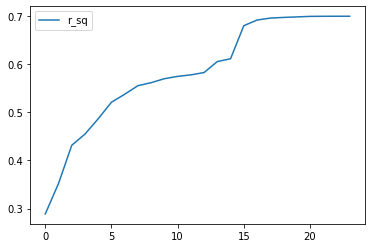

In [ ]:
selected_features = []
r_squared = []
p_value = []

while len(selected_features) != X.shape[1]:
  next_feat = next_possible_feature(X_npf=X, y_npf=y, current_features=selected_features)
  selected_features.append(next_feat[0])
  r_squared.append(next_feat[1])
  p_value.append(next_feat[2])

feats = pd.DataFrame({
    'feature': selected_features,
    'r_sq': r_squared,
    'p-value': np.round(p_value, 5),
    'sig': [get_stars(i) for i in p_value]
})

feats[['feature', 'r_sq']].plot()

In [ ]:
feats

,feature,r_sq,p-value,sig
0,city_people,0.288856,0.00000,****
1,sum_change,0.352162,0.06893,*
2,mean_unempl_days_alltime,0.431516,0.57754,
3,subsidii,0.454865,0.33774,
4,dotation_2022,0.486651,0.19106,
5,max_drop_manuf,0.521055,0.14197,
6,vpk,0.537620,0.24124,
7,forest,0.555418,0.33280,
8,max_drop,0.561687,0.22490,
9,hospital,0.569907,0.46593,


In [ ]:
best_feats = feats.head(20).feature
f = 'cv ~ 1 + ' + ' + '.join(best_feats)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
print(robust.summary())

cv ~ 1 + city_people + sum_change + mean_unempl_days_alltime + subsidii + dotation_2022 + max_drop_manuf + vpk + forest + max_drop + hospital + auto + migration + excess_value_after + excess_value_before + salary + mean_living_subsid + zaderzania + poverty_ratio + mean_unempl_days + sum_drop_manuf
                            OLS Regression Results                            
Dep. Variable:                     cv   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     30.45
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           7.94e-17
Time:                        17:49:31   Log-Likelihood:                -33.748
No. Observations:                  57   AIC:                             109.5
Df Residuals:                      36   BIC:                             152.4
Df Model:                          20                                

In [ ]:
best_feats = ['city_people',# 'salary', 'migration', 'max_drop', 'sum_change', 'sum_drop', 'max_drop_manuf', 'dotation_2022',
       'sum_change_manuf', 'sum_drop_manuf', 'forest', 'auto', 'vpk', 'border']

best_feats = [
    'city_people', 'salary', 'migration', 'mean_living_subsid',
    'sum_change_manuf', 'sum_drop_manuf', 'dotation_2022',
       'forest', 'auto', 'vpk', 'border'
]

f = 'cv ~ 1 + ' + ' + '.join(best_feats)
#f = 'cv ~ 1 + sum_change_manuf + sum_drop_manuf +  auto * vpk'
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
print(robust.summary())

cv ~ 1 + city_people + salary + migration + mean_living_subsid + sum_change_manuf + sum_drop_manuf + dotation_2022 + forest + auto + vpk + border
                            OLS Regression Results                            
Dep. Variable:                     cv   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1.825
Date:                Thu, 23 Mar 2023   Prob (F-statistic):             0.0674
Time:                        17:53:32   Log-Likelihood:                -95.466
No. Observations:                  77   AIC:                             214.9
Df Residuals:                      65   BIC:                             243.1
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|  

In [ ]:
base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]

robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
robust_ols = feats.drop(['p-value', 'sig'], axis=1).set_index('feature').join(robust_ols, how='left')
robust_ols.columns = [i+'_robust' for i in robust_ols.columns]

results = robust_ols.join(base_ols, how='left')
results

NameError: ignored

In [ ]:
#plt.rcParams["figure.figsize"] = (25, 20)
#fig = sm.graphics.plot_partregress_grid(robust)
#fig.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
results[pd.notna(results['sig']) & (results['sig'] != '')]

,r_sq_robust,coef_robust,std_err_robust,z_robust,p-value_robust,CI_l_robust,CI_r_robust,sig_robust,coef,std_err,z,p-value,CI_l,CI_r,sig
feature,,,,,,,,,,,,,,,
forest,0.555418,0.2506,0.097,2.585,0.01,0.061,0.441,**,0.2383,0.081,2.943,0.003,0.08,0.397,***


In [ ]:
def tree_graph(r, title, robust=True):
    def addlabels(x, y, sig):
      for i, j in enumerate(x):
          if j < 0:
            j -= 0.1
          else:
            j += 0.05
          plt.text(j, y[i], sig[i])
    rb = '_robust' if robust else ''
    d = r[pd.notna(r['sig'+rb])]# & (r['sig'+rb] != '')]
    x1 = d[d['coef'+rb] < 0]['coef'+rb].to_list()
    sig1 = d[d['coef'+rb] < 0]['sig'+rb].to_list()
    x2 = d[d['coef'+rb] > 0]['coef'+rb].to_list()
    sig2 = d[d['coef'+rb] > 0]['sig'+rb].to_list()
    y1 = range(len(x1))
    y2 = range(len(x1), (len(x1) + len(x2)))
    y = range(len(x1) + len(x2))
    yl1 = d[d['coef'+rb] < 0].feature.to_list()
    yl2 = d[d['coef'+rb] > 0].feature.to_list()
    fig, axes = plt.subplots(ncols=2, sharey=True)
    bar1 = axes[0].barh(y1, x1, align='center', color='red')
    bar2 = axes[1].barh(y2, x2, align='center', color='blue')
    axes[0].set(yticks=y, yticklabels=yl1 + yl2)
    axes[0].set_xlim([-1, -0.001])
    axes[1].set_xlim([0.001, 1])
    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)
    for i, b in enumerate(bar1):
        if len(sig1[i]):
          b.set_color('mediumorchid')
        else:
          b.set_color('thistle')
    for i, b in enumerate(bar2):
        if len(sig2[i]):
          b.set_color('mediumorchid')
        else:
          b.set_color('thistle')

    '''
    ci1_l = d[d['coef'+rb] < 0]['coef'+rb] - d[d['coef'+rb] < 0]['CI_l'+rb]
    ci1_r = d[d['coef'+rb] < 0]['CI_r'+rb] - d[d['coef'+rb] < 0]['coef'+rb]
    xerr1 = [ci1_l.to_list(), ci1_r.to_list()]
    ci2_l = d[d['coef'+rb] > 0]['coef'+rb] - d[d['coef'+rb] > 0]['CI_l'+rb]
    ci2_r = d[d['coef'+rb] > 0]['CI_r'+rb] - d[d['coef'+rb] > 0]['coef'+rb]
    xerr2 = [ci2_l.to_list(), ci2_r.to_list()]
    axes[0].errorbar(x1, y1, xerr=xerr1,
        fmt='none',     # don't connect data points
        ecolor='black', # color of error lines
        elinewidth=1,   # width of error lines
        capsize=4,      # length of error caps
        zorder=-1,      # put error bars behind scatter points
    )
    axes[1].errorbar(x2, y2, xerr=xerr2,
        fmt='none',     # don't connect data points
        ecolor='black', # color of error lines
        elinewidth=1,   # width of error lines
        capsize=4,      # length of error caps
        zorder=-1,      # put error bars behind scatter points
    )
    '''
    addlabels(x1, y1, sig1)
    addlabels(x2, y2, sig2)
    axes[0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
    axes[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
    fig.suptitle(title, x=0.63)
    #fig.text(0.63, 0, 'Стандартизованный коэффициент β', ha='center')
    fig.text(0.63, 0, 'Средний вклад на единицу изменения фактора (β)', ha='center')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, top=0.93)
    plt.show()

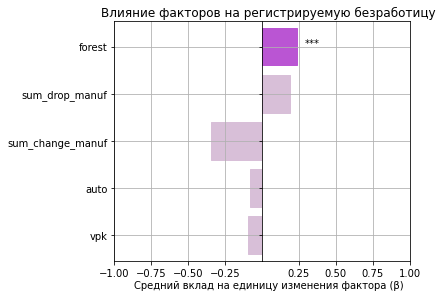

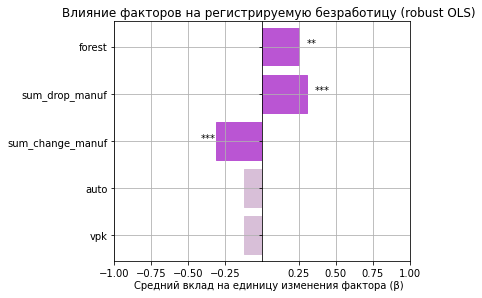

In [ ]:
ren = {'city_people': 'Доля городского\nнаселения',
       'vote_turnout': 'Явка на голосование\n по поправкам',
       'internet': 'Доступ к интернету',
       'poverty_ratio': 'Доля бедного\nнаселения',
       'income': 'Располагаемые ресурсы\nдомохозяйства',
       'subsidii': 'Социальные выплаты\n населению',
       'excessive_voices': 'Избыточные голоса\nна выборах за ЕР',
       'zaderzania': 'Задержания\nна протестных акциях',
       }
r = results.copy().sort_values(by=['sig']).reset_index()
r['feature'] = r['feature'].apply(lambda x: ren[x] if x in ren else x)
#'Безработица по данным резюме портала "Работа в России" (OLS)'
tree_graph(r, robust=False, title='Влияние факторов на регистрируемую безработицу')
tree_graph(r, robust=True, title='Влияние факторов на регистрируемую безработицу (robust OLS)')

## Мобилизация на данных избыточных свадеб

In [ ]:
cols = ['economic_growth',
 'gossluz',
 'income',
 'vote_turnout',
 #'rate_yes',
 'internet',
 'city_people',
 'salary',
 'migration',
 #'hospital',
 'subsidii',
 'cv',
 #'indebted',
 'poverty_ratio',
 'zaderzania',
 'antiwar_zaderzania',
 'subsidii_flat',
 'subsidised_families_flat',
 'excess_value_before', 'excess_value_after']
tmp = main_df_norm_scaled.dropna(subset=cols + ['weddings'])
X = tmp[cols]
y = tmp['weddings']

In [ ]:
main_df_norm_scaled.dropna(subset=cols + ['weddings'])[['subsidii_flat', 'indebted', 'income']].corr()

,subsidii_flat,indebted,income
subsidii_flat,1.000000,0.199599,0.313958
indebted,0.199599,1.000000,0.740418
income,0.313958,0.740418,1.000000


<AxesSubplot:>

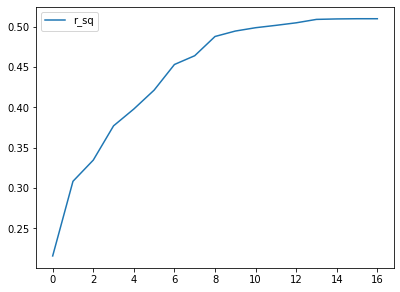

In [ ]:
selected_features = []
r_squared = []
p_value = []

while len(selected_features) != X.shape[1]:
  next_feat = next_possible_feature(X_npf=X, y_npf=y, current_features=selected_features)
  selected_features.append(next_feat[0])
  r_squared.append(next_feat[1])
  p_value.append(next_feat[2])

feats = pd.DataFrame({
    'feature': selected_features,
    'r_sq': r_squared,
    'p-value': np.round(p_value, 5),
    'sig': [get_stars(i) for i in p_value]
})

feats[['feature', 'r_sq']].plot()

In [ ]:
feats

,feature,r_sq,p-value,sig
0,economic_growth,0.215983,0.10669,
1,cv,0.308470,0.02917,**
2,gossluz,0.334714,0.17884,
3,income,0.377174,0.00770,***
4,internet,0.398053,0.39650,
5,migration,0.421448,0.35926,
6,subsidii_flat,0.453185,0.13272,
7,subsidised_families_flat,0.464058,0.70159,
8,salary,0.487887,0.48919,
9,subsidii,0.494613,0.76783,


In [ ]:
best_feats = feats.head(8).feature
f = 'weddings ~ 1 + ' + ' + '.join(best_feats)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
print(robust.summary())

weddings ~ 1 + economic_growth + cv + gossluz + income + internet + migration + subsidii_flat + subsidised_families_flat
                            OLS Regression Results                            
Dep. Variable:               weddings   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     13.25
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           2.29e-10
Time:                        19:45:20   Log-Likelihood:                -67.728
No. Observations:                  63   AIC:                             153.5
Df Residuals:                      54   BIC:                             172.7
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.9

In [ ]:
best_feats = cols = ['city_people',# 'salary', 'migration', 'max_drop', 'sum_change', 'sum_drop', 'max_drop_manuf', 'dotation_2022',
       'sum_change_manuf', 'sum_drop_manuf', 'forest', 'auto', 'vpk', 'border']
f = 'weddings ~ 1 + ' + ' + '.join(best_feats)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
print(robust.summary())

weddings ~ 1 + city_people + sum_change_manuf + sum_drop_manuf + forest + auto + vpk + border
                            OLS Regression Results                            
Dep. Variable:               weddings   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     5.975
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           3.94e-05
Time:                        17:42:13   Log-Likelihood:                -78.485
No. Observations:                  60   AIC:                             173.0
Df Residuals:                      52   BIC:                             189.7
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

In [ ]:
base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]

robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
robust_ols = feats.drop(['p-value', 'sig'], axis=1).set_index('feature').join(robust_ols, how='left')
robust_ols.columns = [i+'_robust' for i in robust_ols.columns]

results = robust_ols.join(base_ols, how='left')
results

,r_sq_robust,coef_robust,std_err_robust,z_robust,p-value_robust,CI_l_robust,CI_r_robust,sig_robust,coef,std_err,z,p-value,CI_l,CI_r,sig
feature,,,,,,,,,,,,,,,
city_people,0.288856,0.3701,0.070,5.273,0.000,0.233,0.508,****,0.3369,0.071,4.745,0.000,0.198,0.476,****
sum_change,0.352162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_unempl_days_alltime,0.431516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subsidii,0.454865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dotation_2022,0.486651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_drop_manuf,0.521055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vpk,0.537620,0.0157,0.084,0.186,0.853,-0.150,0.181,,-0.0009,0.148,-0.006,0.995,-0.292,0.290,
forest,0.555418,0.1039,0.074,1.403,0.161,-0.041,0.249,,0.1301,0.139,0.938,0.348,-0.142,0.402,
max_drop,0.561687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#plt.rcParams["figure.figsize"] = (25, 20)
#fig = sm.graphics.plot_partregress_grid(robust)
#fig.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

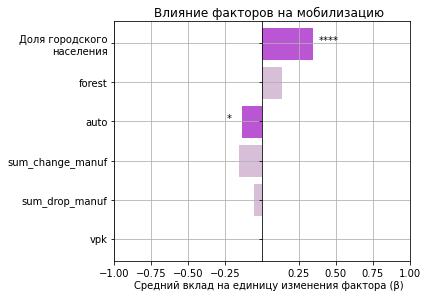

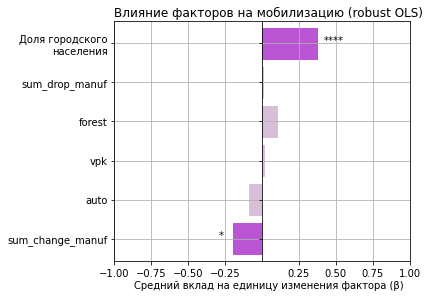

In [ ]:
ren = {'city_people': 'Доля городского\nнаселения',
       'vote_turnout': 'Явка на голосование\n по поправкам',
       'internet': 'Доступ к интернету',
       'poverty_ratio': 'Доля бедного\nнаселения',
       'income': 'Располагаемые ресурсы\nдомохозяйства',
       'subsidii': 'Социальные выплаты\n населению',
       'excessive_voices': 'Избыточные голоса\nна выборах за ЕР',
       'zaderzania': 'Задержания\nна протестных акциях',
       'gossluz': 'Доля госслужащих',
       'cv': 'Регистрируемая безработица',
       'economic_growth': 'Экономический рост (ВРП)',
       'migration': 'Миграция',
       'subsidii_flat': 'Размер жилищной субсидии',
       'subsidised_families_flat': 'Доля семей, получивших\nжилищную субсидию',
       }
r = results.copy().sort_values(by=['sig']).reset_index()
r['feature'] = r['feature'].apply(lambda x: ren[x] if x in ren else x)
#'Безработица по данным резюме портала "Работа в России" (OLS)'
#tree_graph(r, robust=False, title='Безработица по данным резюме портала "Работа в России" (OLS)')
tree_graph(r, robust=False, title='Влияние факторов на мобилизацию')
tree_graph(r, robust=True, title='Влияние факторов на мобилизацию (robust OLS)')

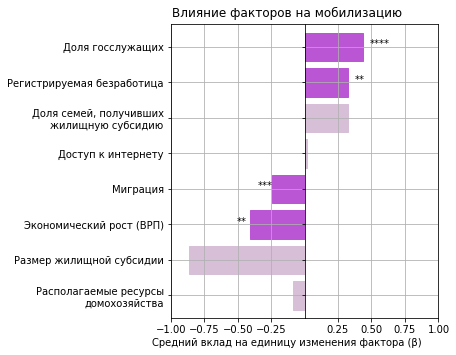

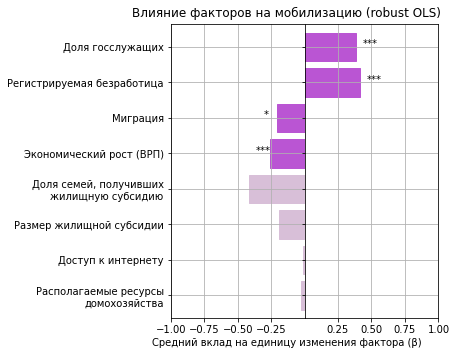

In [ ]:
ren = {'city_people': 'Доля городского\nнаселения',
       'vote_turnout': 'Явка на голосование\n по поправкам',
       'internet': 'Доступ к интернету',
       'poverty_ratio': 'Доля бедного\nнаселения',
       'income': 'Располагаемые ресурсы\nдомохозяйства',
       'subsidii': 'Социальные выплаты\n населению',
       'excessive_voices': 'Избыточные голоса\nна выборах за ЕР',
       'zaderzania': 'Задержания\nна протестных акциях',
       'gossluz': 'Доля госслужащих',
       'cv': 'Регистрируемая безработица',
       'economic_growth': 'Экономический рост (ВРП)',
       'migration': 'Миграция',
       'subsidii_flat': 'Размер жилищной субсидии',
       'subsidised_families_flat': 'Доля семей, получивших\nжилищную субсидию',
       }
r = results.copy().sort_values(by=['sig']).reset_index()
r['feature'] = r['feature'].apply(lambda x: ren[x] if x in ren else x)
#'Безработица по данным резюме портала "Работа в России" (OLS)'
#tree_graph(r, robust=False, title='Безработица по данным резюме портала "Работа в России" (OLS)')
tree_graph(r, robust=False, title='Влияние факторов на мобилизацию')
tree_graph(r, robust=True, title='Влияние факторов на мобилизацию (robust OLS)')

## Мобилизация на данных избыточных свадеб + эксцесс

In [ ]:
cols = ['economic_growth',
 'gossluz',
 'income',
 'vote_turnout',
 #'rate_yes',
 'internet',
 'city_people',
 'salary',
 'migration',
 #'hospital',
 'subsidii',
 #'cv',
 #'indebted',
 'poverty_ratio',
 'zaderzania',
 'antiwar_zaderzania',
 'subsidii_flat',
 'subsidised_families_flat',
 'excess_value_before', 'excess_value_after']
tmp = main_df_norm_scaled.dropna(subset=cols + ['weddings'])
X = tmp[cols]
y = tmp['weddings']

In [ ]:
main_df_norm_scaled.dropna(subset=cols + ['weddings'])[['subsidii_flat', 'indebted', 'income']].corr()

,subsidii_flat,indebted,income
subsidii_flat,1.000000,0.199599,0.313958
indebted,0.199599,1.000000,0.740418
income,0.313958,0.740418,1.000000


<AxesSubplot:>

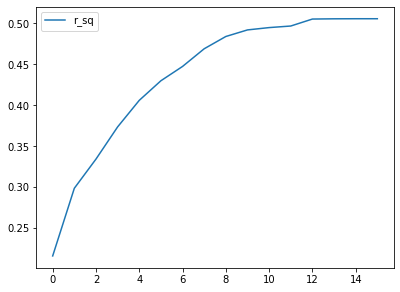

In [ ]:
selected_features = []
r_squared = []
p_value = []

while len(selected_features) != X.shape[1]:
  next_feat = next_possible_feature(X_npf=X, y_npf=y, current_features=selected_features)
  selected_features.append(next_feat[0])
  r_squared.append(next_feat[1])
  p_value.append(next_feat[2])

feats = pd.DataFrame({
    'feature': selected_features,
    'r_sq': r_squared,
    'p-value': np.round(p_value, 5),
    'sig': [get_stars(i) for i in p_value]
})

feats[['feature', 'r_sq']].plot()

In [ ]:
feats

,feature,r_sq,p-value,sig
0,economic_growth,0.215983,0.10669,
1,gossluz,0.298648,0.02499,**
2,income,0.334276,0.16065,
3,internet,0.373596,0.22700,
4,migration,0.406046,0.08112,*
5,subsidii_flat,0.429986,0.24290,
6,subsidised_families_flat,0.447473,0.59209,
7,salary,0.469062,0.49264,
8,subsidii,0.484055,0.69170,
9,poverty_ratio,0.492087,0.45806,


In [ ]:
best_feats = feats.head(10).feature
f = 'weddings ~ 1 + ' + ' + '.join(best_feats)
print(f)
ols = smf.ols(f, main_df_norm_scaled).fit(cov_type='HC1')
print(ols.summary())

robust = smf.rlm(f, main_df_norm_scaled, M=sm.robust.norms.HuberT()).fit() #TrimmedMean(0.5)
print(robust.summary())

weddings ~ 1 + economic_growth + gossluz + income + internet + migration + subsidii_flat + subsidised_families_flat + salary + subsidii + poverty_ratio
                            OLS Regression Results                            
Dep. Variable:               weddings   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     6.203
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           3.71e-06
Time:                        19:46:12   Log-Likelihood:                -68.675
No. Observations:                  63   AIC:                             159.3
Df Residuals:                      52   BIC:                             182.9
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                               coef    std err          z 

In [ ]:
base_ols = pd.read_html(ols.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
base_ols['sig'] = [get_stars(i) for i in base_ols['p-value']]

robust_ols = pd.read_html(robust.summary().tables[1].as_html(), header=0, index_col=0)[0].rename(columns={'P>|z|' : 'p-value',
                                                                            'std err' : 'std_err',
                                                                            '[0.025' : 'CI_l',
                                                                            '0.975]' : 'CI_r'})
robust_ols['sig'] = [get_stars(i) for i in robust_ols['p-value']]
robust_ols = feats.drop(['p-value', 'sig'], axis=1).set_index('feature').join(robust_ols, how='left')
robust_ols.columns = [i+'_robust' for i in robust_ols.columns]

results = robust_ols.join(base_ols, how='left')
results

,r_sq_robust,coef_robust,std_err_robust,z_robust,p-value_robust,CI_l_robust,CI_r_robust,sig_robust,coef,std_err,z,p-value,CI_l,CI_r,sig
feature,,,,,,,,,,,,,,,
economic_growth,0.215983,-0.2992,0.083,-3.596,0.000,-0.462,-0.136,****,-0.4211,0.183,-2.305,0.021,-0.779,-0.063,**
gossluz,0.298648,0.4711,0.137,3.427,0.001,0.202,0.741,***,0.4556,0.140,3.247,0.001,0.181,0.731,***
income,0.334276,-0.0179,0.110,-0.162,0.871,-0.234,0.198,,-0.0471,0.094,-0.503,0.615,-0.230,0.136,
internet,0.373596,-0.0072,0.102,-0.071,0.944,-0.207,0.192,,0.0688,0.156,0.441,0.660,-0.237,0.375,
migration,0.406046,-0.1122,0.124,-0.902,0.367,-0.356,0.132,,-0.1695,0.102,-1.662,0.097,-0.369,0.030,*
subsidii_flat,0.429986,-0.4677,0.500,-0.935,0.350,-1.448,0.512,,-1.2729,0.850,-1.498,0.134,-2.938,0.392,
subsidised_families_flat,0.447473,0.0834,0.476,0.175,0.861,-0.849,1.016,,0.8530,0.787,1.084,0.278,-0.690,2.396,
salary,0.469062,-0.0335,0.085,-0.396,0.692,-0.199,0.132,,0.0631,0.096,0.656,0.512,-0.125,0.252,
subsidii,0.484055,0.3095,0.277,1.119,0.263,-0.233,0.852,,0.4403,0.335,1.313,0.189,-0.217,1.098,


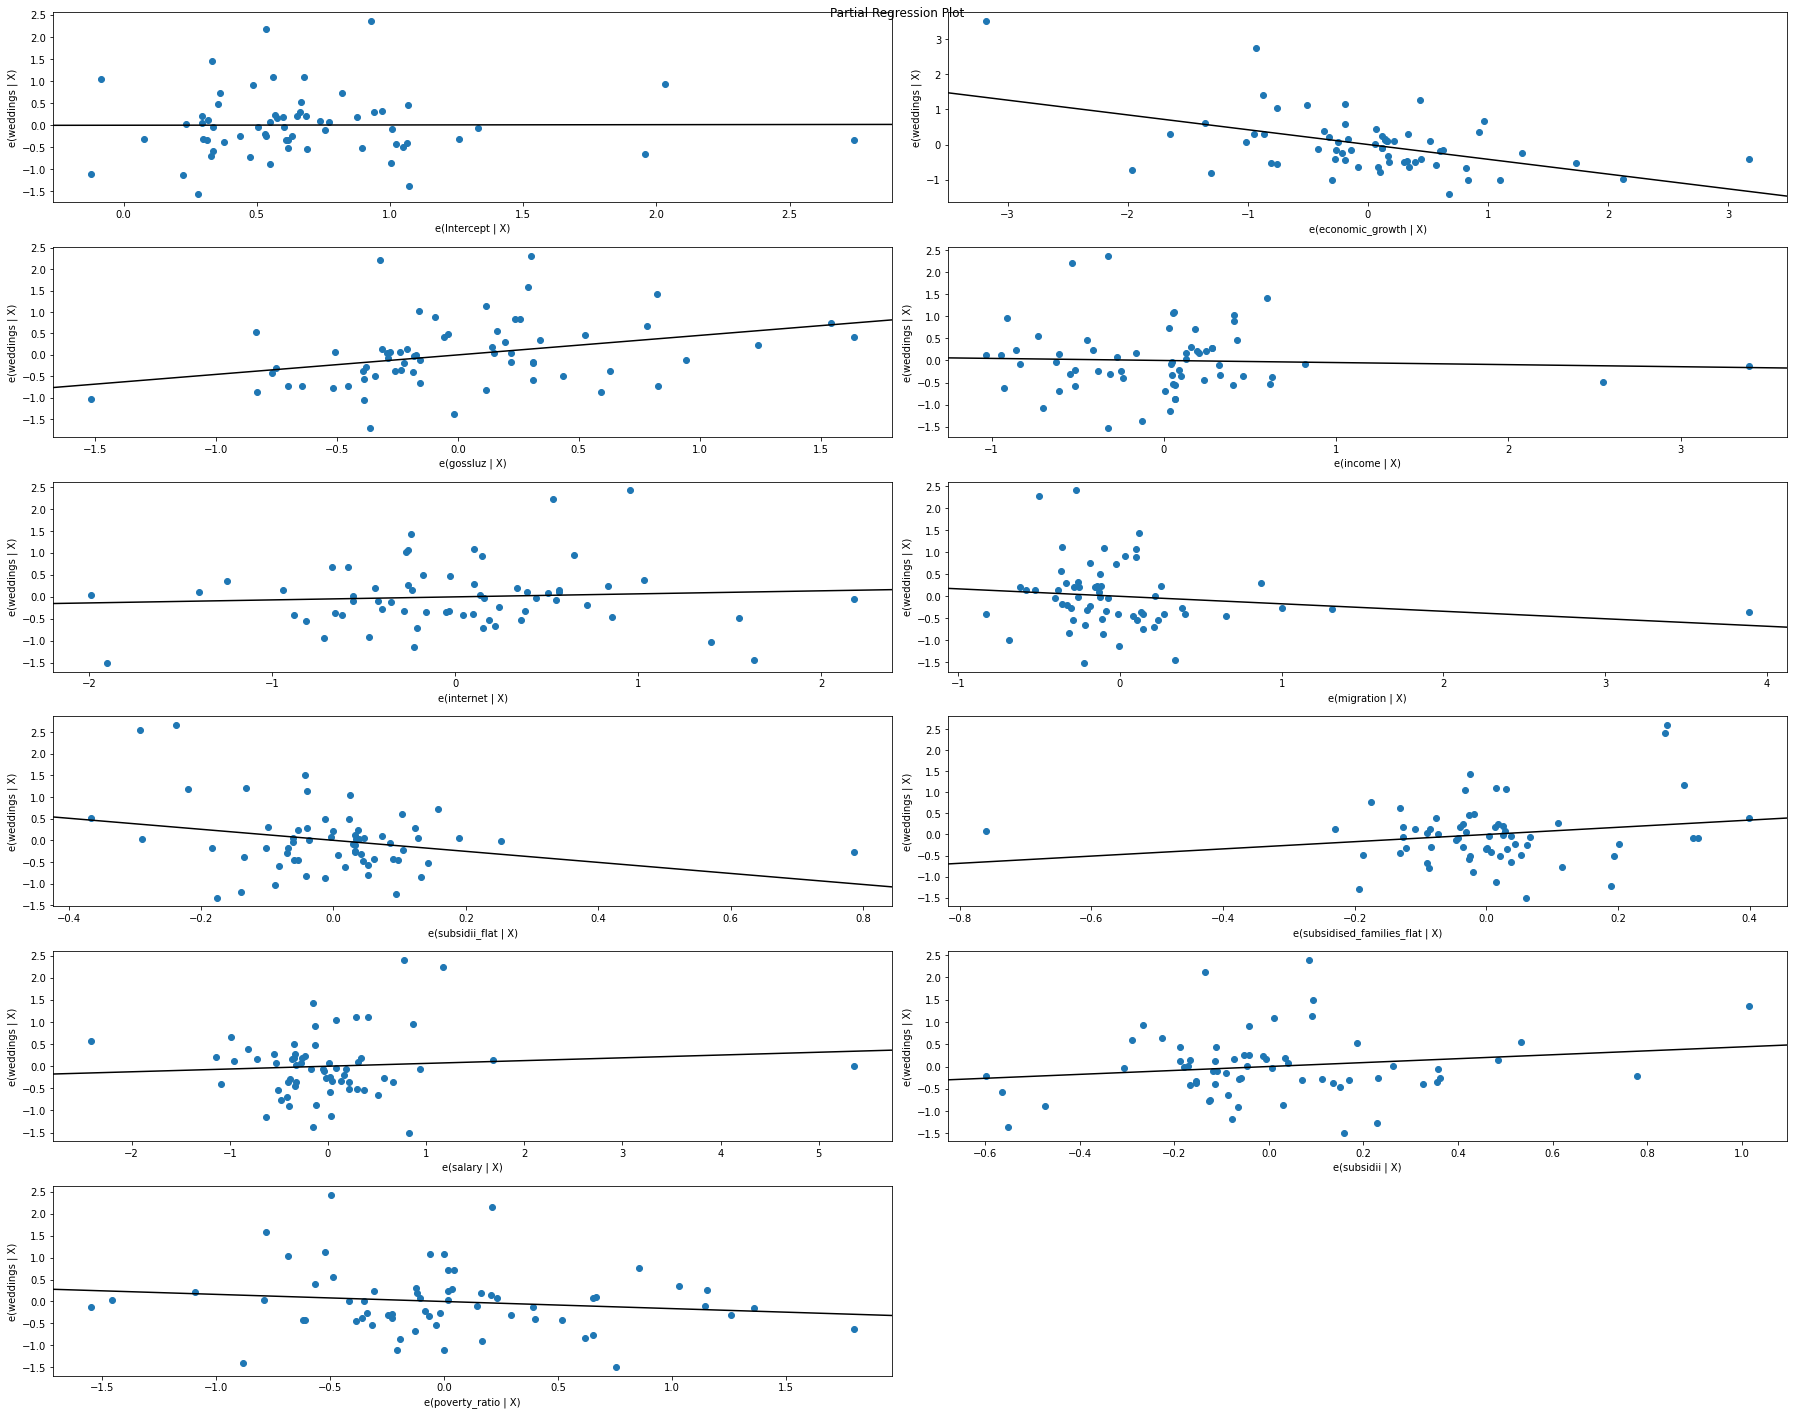

In [ ]:
plt.rcParams["figure.figsize"] = (25, 20)
fig = sm.graphics.plot_partregress_grid(robust)
fig.tight_layout(pad=1.0)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

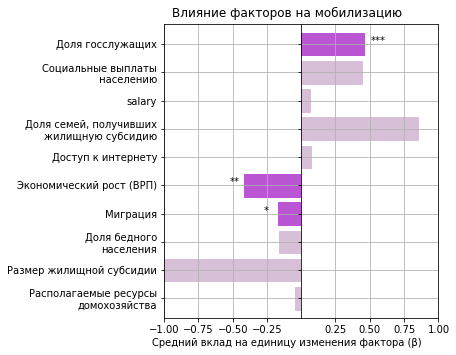

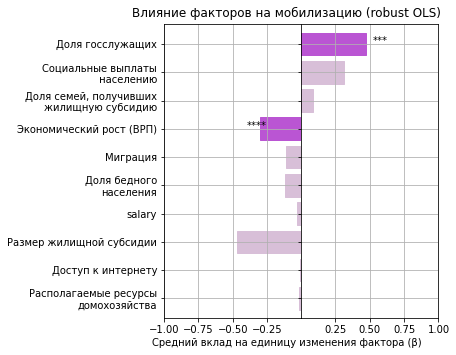

In [ ]:
ren = {'city_people': 'Доля городского\nнаселения',
       'vote_turnout': 'Явка на голосование\n по поправкам',
       'internet': 'Доступ к интернету',
       'poverty_ratio': 'Доля бедного\nнаселения',
       'income': 'Располагаемые ресурсы\nдомохозяйства',
       'subsidii': 'Социальные выплаты\n населению',
       'excessive_voices': 'Избыточные голоса\nна выборах за ЕР',
       'zaderzania': 'Задержания\nна протестных акциях',
       'gossluz': 'Доля госслужащих',
       'cv': 'Регистрируемая безработица',
       'economic_growth': 'Экономический рост (ВРП)',
       'migration': 'Миграция',
       'subsidii_flat': 'Размер жилищной субсидии',
       'subsidised_families_flat': 'Доля семей, получивших\nжилищную субсидию',
       }
r = results.copy().sort_values(by=['sig']).reset_index()
r['feature'] = r['feature'].apply(lambda x: ren[x] if x in ren else x)
#'Безработица по данным резюме портала "Работа в России" (OLS)'
#tree_graph(r, robust=False, title='Безработица по данным резюме портала "Работа в России" (OLS)')
tree_graph(r, robust=False, title='Влияние факторов на мобилизацию')
tree_graph(r, robust=True, title='Влияние факторов на мобилизацию (robust OLS)')

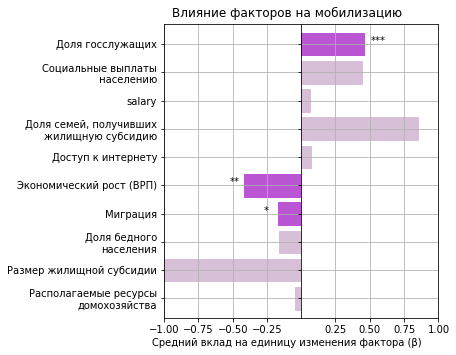

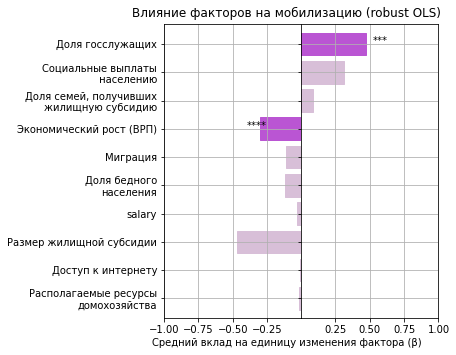

In [ ]:
ren = {'city_people': 'Доля городского\nнаселения',
       'vote_turnout': 'Явка на голосование\n по поправкам',
       'internet': 'Доступ к интернету',
       'poverty_ratio': 'Доля бедного\nнаселения',
       'income': 'Располагаемые ресурсы\nдомохозяйства',
       'subsidii': 'Социальные выплаты\n населению',
       'excessive_voices': 'Избыточные голоса\nна выборах за ЕР',
       'zaderzania': 'Задержания\nна протестных акциях',
       'gossluz': 'Доля госслужащих',
       'cv': 'Регистрируемая безработица',
       'economic_growth': 'Экономический рост (ВРП)',
       'migration': 'Миграция',
       'subsidii_flat': 'Размер жилищной субсидии',
       'subsidised_families_flat': 'Доля семей, получивших\nжилищную субсидию',
       }
r = results.copy().sort_values(by=['sig']).reset_index()
r['feature'] = r['feature'].apply(lambda x: ren[x] if x in ren else x)
#'Безработица по данным резюме портала "Работа в России" (OLS)'
#tree_graph(r, robust=False, title='Безработица по данным резюме портала "Работа в России" (OLS)')
tree_graph(r, robust=False, title='Влияние факторов на мобилизацию')
tree_graph(r, robust=True, title='Влияние факторов на мобилизацию (robust OLS)')

## Разное

In [ ]:
main_df_norm.sort_values('vote_turnout', ascending=True)[['region_code', 'vote_turnout']]

,region_code,vote_turnout
19,4100000000000,44.08
15,3800000000000,44.18
76,2700000000000,44.24
71,7000000000000,44.57
32,5100000000000,45.15
...,...,...
5,3200000000000,89.36
48,500000000000,89.99
46,200000000000,90.83
59,1700000000000,92.80


Text(0, 0.5, 'weddings')

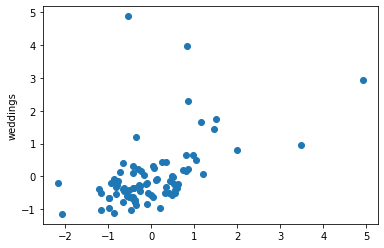

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig = plt.scatter(main_df_norm_scaled['cv'], main_df_norm_scaled['gossluz'])
#for i, t in enumerate(txt):
#    ax.annotate(t, (main_df_norm_scaled['weddings'][i], main_df_norm_scaled['vote_turnout'][i]))
ax.set_ylabel("weddings")

In [ ]:
main_df_norm_scaled.corr()

,economic_growth,population,excessive_voices,gossluz,income,vote_turnout,rate_yes,internet,_8014006,city_people,...,cv,poteri,mobiliz,dobrovol,Место,"Соотношение среднедушевого долга по кредитам и годовой зарплаты в начале 2022 г., %",indebted,"Изменение задолженности на одного человека за год, тыс. руб.",zaderzania,antiwar_zaderzania
economic_growth,1.000000,-0.002295,0.200503,-0.188306,-0.104478,0.055196,0.150609,-0.091768,-0.157727,-0.021522,...,-0.130075,-0.096401,0.007713,-0.090125,0.147863,0.084745,-0.144164,-0.137827,0.064717,0.064717
population,-0.002295,1.000000,0.105517,-0.495609,0.402793,0.154201,0.085919,0.321491,0.050385,-0.240172,...,-0.413131,-0.402963,-0.114058,-0.202744,0.006746,-0.048905,0.104407,0.218261,0.582568,0.582568
excessive_voices,0.200503,0.105517,1.000000,-0.032660,-0.084845,0.749090,0.710749,0.170371,0.192104,-0.001265,...,-0.153111,-0.007647,0.063514,-0.174368,-0.149041,-0.240861,-0.224496,-0.196563,-0.038184,-0.038184
gossluz,-0.188306,-0.495609,-0.032660,1.000000,0.212240,-0.167611,-0.268161,0.100482,-0.055512,0.747572,...,0.510697,0.472063,0.608821,0.261976,-0.246236,-0.199482,0.331456,0.311196,-0.356746,-0.356746
income,-0.104478,0.402793,-0.084845,0.212240,1.000000,-0.207377,-0.304513,0.425696,-0.055137,0.248312,...,0.042909,-0.204061,0.180342,-0.046133,-0.320011,-0.240881,0.654521,0.592978,-0.051405,-0.051405
vote_turnout,0.055196,0.154201,0.749090,-0.167611,-0.207377,1.000000,0.863882,0.276876,0.173286,-0.081531,...,-0.203029,0.007936,0.007832,-0.029512,-0.005582,-0.082696,-0.222262,-0.153524,-0.068640,-0.068640
rate_yes,0.150609,0.085919,0.710749,-0.268161,-0.304513,0.863882,1.000000,0.177006,0.127630,-0.320261,...,-0.355613,-0.041816,-0.062064,-0.235212,0.073188,-0.025921,-0.346861,-0.293736,-0.078795,-0.078795
internet,-0.091768,0.321491,0.170371,0.100482,0.425696,0.276876,0.177006,1.000000,-0.030816,0.123652,...,-0.041669,-0.034896,0.220492,-0.079690,-0.278100,-0.290816,0.300003,0.356000,0.052566,0.052566
_8014006,-0.157727,0.050385,0.192104,-0.055512,-0.055137,0.173286,0.127630,-0.030816,1.000000,0.027899,...,0.059457,-0.087228,-0.031133,-0.084733,-0.085221,-0.023129,-0.006200,-0.004476,-0.066192,-0.066192
city_people,-0.021522,-0.240172,-0.001265,0.747572,0.248312,-0.081531,-0.320261,0.123652,0.027899,1.000000,...,0.443863,0.264011,0.611573,0.313078,-0.283590,-0.273717,0.341875,0.383291,0.073150,0.073150


In [ ]:
import plotly.express as px
fig = px.imshow(main_df_norm_scaled.corr())
fig.show()

Text(0.5, 0, 'vote_turnout')

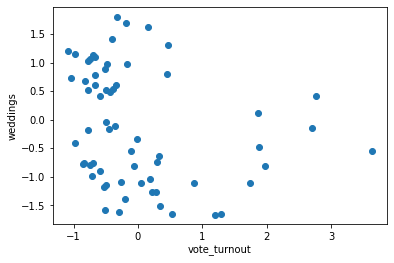

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig = plt.scatter(main_df_norm_scaled['weddings'], main_df_norm_scaled['vote_turnout'])
#for i, t in enumerate(txt):
#    ax.annotate(t, (main_df_norm_scaled['weddings'][i], main_df_norm_scaled['vote_turnout'][i]))
ax.set_ylabel("weddings")
ax.set_xlabel("vote_turnout")

Text(0.5, 1.0, 'weddings ~ 1 + cv + economic_growth + gossluz + subsidii_flat + subsidised_families_flat + salary + income + subsidii')

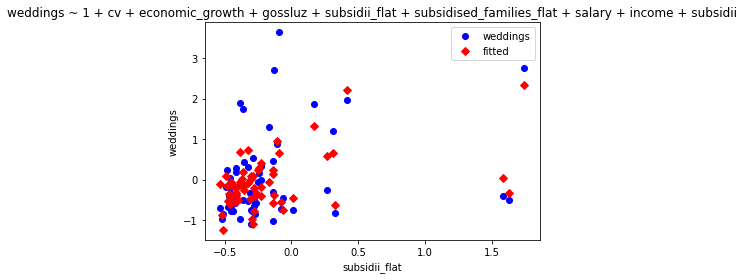

In [ ]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(robust, 4, ax=ax, vlines=False)
ax.set_ylabel("weddings")
#ax.set_xlabel("Poverty Level")
ax.set_title(f)

In [ ]:
%%capture
!pip install semopy
import semopy as sem

In [ ]:
main_df_norm_scaled

,economic_growth,population,excessive_voices,gossluz,income,vote_turnout,rate_yes,internet,_8014006,city_people,...,subsidii,weddings,region_code,cv,poteri,mobiliz,dobrovol,zaderzania,antiwar_zaderzania,mean_living_subsid
0,0.866882,0.304485,-0.744301,-0.197113,-0.608723,-1.260881,-0.438350,-0.990731,-0.121728,-0.336482,...,-0.374578,0.287209,-0.839666,-0.103646,-0.288497,-0.314968,-0.404579,-0.205610,-0.205610,-0.006257
1,-3.009655,-0.552117,-0.561823,0.327681,0.042430,-0.544012,-0.597209,0.480139,-0.122400,-0.253071,...,-0.177103,3.635036,-0.597566,0.048211,-0.232196,-0.142702,-0.772759,-0.214870,-0.214870,-0.119320
2,0.309471,-0.381257,-1.300807,-0.231579,2.437206,-1.180159,-1.091913,-0.295049,-0.105498,-0.189465,...,-0.119417,-0.530543,-0.557215,0.537629,-0.346698,-0.275442,0.050833,-0.175302,-0.175302,-0.423816
3,3.628598,-0.429231,0.299881,-0.232462,-0.124047,0.510556,1.141716,0.360879,-0.121531,-0.674605,...,-0.277002,-0.496245,-0.516865,-0.113509,-0.189735,-0.269081,-0.290995,-0.208135,-0.208135,-0.290685
4,0.233461,-0.132488,0.745406,-0.494205,-0.085236,0.977854,0.611829,-0.950978,-0.110024,-0.256671,...,-0.043851,-0.172351,-0.476515,0.565923,-0.068980,0.447667,-0.107891,-0.057439,-0.057439,-0.087317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,-0.830687,-0.182821,2.047833,-0.384613,-0.949408,2.119808,2.334761,1.951009,-0.133226,-0.354922,...,-0.268267,NaN,-0.920366,-0.659756,0.049959,-0.350254,3.456444,NaN,NaN,-0.072078
80,-0.856023,-0.312765,-0.164852,-0.707910,-0.713654,-0.178172,-0.367983,-1.249127,-0.111124,0.014580,...,-0.262446,-0.769397,-0.880016,-0.374144,-0.021541,-0.282970,0.236304,-0.207293,-0.207293,0.594711
81,-0.247939,-0.965798,0.705389,4.877959,1.245019,0.681627,0.456168,1.414340,-0.092271,4.087242,...,4.473456,NaN,1.783089,-0.529765,1.389902,7.937044,-0.880408,NaN,NaN,0.433521
82,0.461493,-0.439158,1.417695,1.190537,3.905613,1.054873,1.400795,2.348541,-0.111333,-0.272832,...,-0.121335,-0.747912,1.863790,-0.348697,-1.257111,-0.350254,-0.537568,-0.216554,-0.216554,-0.130199


                      Value
DoF            4.300000e+01
DoF Baseline   5.800000e+01
chi2           1.351751e+02
chi2 p-value   1.853140e-11
chi2 Baseline  2.980239e+02
CFI            6.159755e-01
GFI            5.464288e-01
AGFI           3.882063e-01
NFI            5.464288e-01
TLI            4.820134e-01
RMSEA          1.607065e-01
AIC            4.275600e+01
BIC            9.866478e+01
LogLik         1.622001e+00


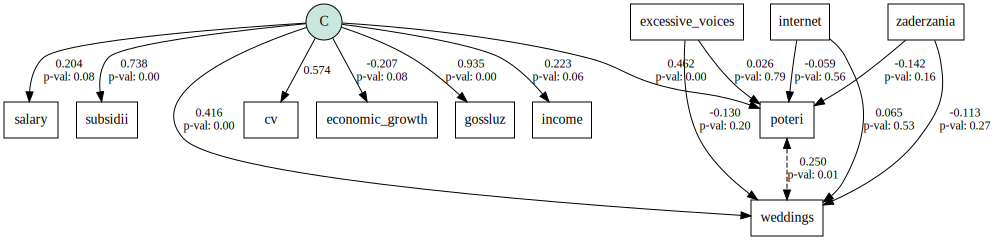

In [ ]:
formula = """
weddings ~~ poteri

C =~ cv + economic_growth + income + subsidii + salary + gossluz
weddings ~ C + zaderzania + excessive_voices + internet
poteri ~ C + zaderzania + excessive_voices + internet
"""
model = sem.Model(formula)
model.fit(main_df_norm_scaled, obj="MLW", solver="SLSQP") #MLW ULS GLS FIML DWLS WLS
sem.bias_correction(model, n=100, resample_mean=True)
print(sem.calc_stats(model).T)
sem.semplot(model, "fig19.pdf", plot_covs=True, std_ests=True, show=True)